### Foreword

This file visualizes all of the executed experiments, for which the results were stored in `.pickle` files. In order to reproduce the results, please take a look at the [ReadME](./README.md) and the experiment files: [experiments.ipynb](experiments.ipynb) and [experiments_history.ipynb](experiments_history.ipynb).

All results for the hyper-parameter optimization part are computed for 5000 random users, such that performance is generalizable to all users (selecting the first 5000 doesn't work because users are sorted on inventory size, thus biasing training towards users with large inventory sizes) and for a k-value of 10, as this provides a good balance between values of 5/10/20.
The final overview shows results for different k-values, where metrics are computed for all users in the dataset across three different splits. This confirms that the performance is generalizable, even across different k-values, users and item splits.

#### Visualization helper functions

In [1]:
import seaborn as sns
import pickle
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

def visualize(labels, values, key, xlabel, width=30):
    colors = sns.color_palette("husl", len(values))
    values = [value*100 for value in values]
    fig_dims = (width, 6)
    fig, ax = plt.subplots(figsize=fig_dims)
    ax.set(xlabel=xlabel, ylabel=key + ' (%)')
    values = np.array(values)
    order = np.argsort(values)
    ordered_values = values[order]
    ordered_labels = np.array(labels)[order]
    ordered_colors = np.array(colors)[order]
    ordered_colors = [tuple(color) for color in ordered_colors]
    plt.xticks(rotation=270)
    sns.barplot(x=ordered_labels, y=ordered_values, ax=ax, palette=ordered_colors)
    leg = ax.legend(labels=ordered_labels, bbox_to_anchor=(1, 1.01))
    for handle, color in zip(leg.legendHandles, ordered_colors):
        handle.set_color(color)
    ax.set(xticklabels=[])
    ax.bar_label(ax.containers[0])
    
def average(results, n_splits=3):
    return sum(results[:n_splits])/n_splits

### Removing popularity bias

The following visualization shows results on the pre-processed dataset. All owned games are present.

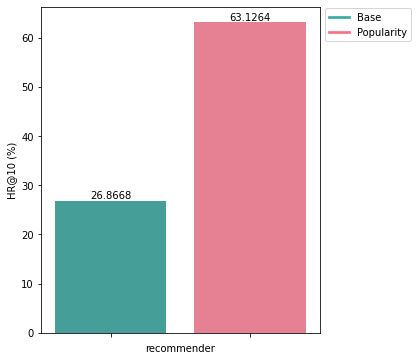

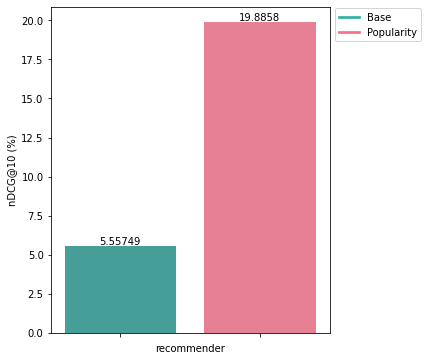

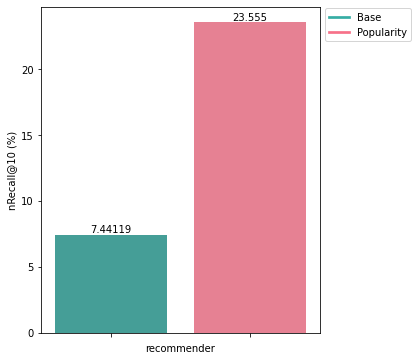

In [11]:
results = []
labels = ['PopBased', 'BaseRecommender']
actual_labels = ['Popularity', 'Base']

for label in labels:
    with open(f'./evaluation/v2/quantitative/{label}.pickle.gz', 'rb') as handle:
        results.append(pickle.load(handle))
    
for key in results[0].keys():
    if key[-2:] == '10' and key[:-3] not in ['ideal_recall', 'recall']:
        values = [average(result[key]) for result in results]
        visualize(actual_labels, values, key, 'recommender', width=5)

We see that there is a significant popularity bias in the Steam dataset. A popularity-based recommender is already very powerful and it will be hard to beat these results. However, the results are not representative of good recommender behaviour, since we desire that the recommendations are personalized. Therefore, it's better to remove a portion of games such that the popularity bias is mitigated.

Thus, we remove the top 1% most popular games and compare the results.

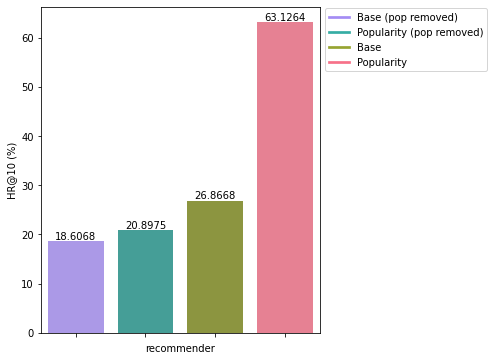

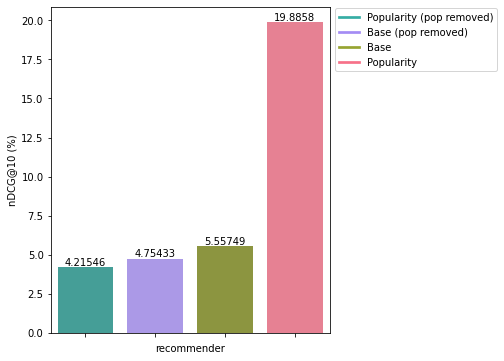

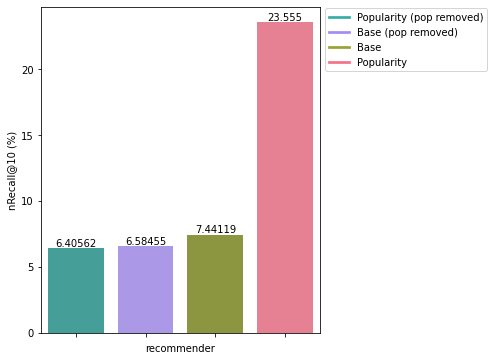

In [7]:
results = []
labels = ['PopBased', 'BaseRecommender']
actual_labels = ['Popularity', 'Base', 'Popularity (pop removed)', 'Base (pop removed)']

for label in labels:
    with open(f'./evaluation/v2/quantitative/{label}.pickle.gz', 'rb') as handle:
        results.append(pickle.load(handle))
        
for label in labels:
    with open(f'./evaluation/v3/quantitative/{label}.pickle.gz', 'rb') as handle:
        results.append(pickle.load(handle))
    
for key in results[0].keys():
    if key[-2:] == '10' and key[:-3] not in ['ideal_recall', 'recall']:
        values = [average(result[key]) for result in results]
        visualize(actual_labels, values, key, 'recommender', width=5)

We see that the quantitative results for the popularity based recommender have decreased dramaticallyn while those for the content-based recommender have only been reduced slightly. This shows that the content-based recommender already focuses on more personalized recommendations. The popularity-based recommender is still very close however, and even outperforms the content-based recommender. Therefore, in what follows, we try to introduce some optimizations in order to improve the content-based recommender system.

# Hyper-parameter optimization

### Optimization 1: Augmented item representation

We think that better item representations could result in better quantitative performance, since our recommender would be able to better distinguish between games. Therefore, we try to add more information to the item representations. To determine what item representation is optimal, we perform a grid search across the possible configurations.

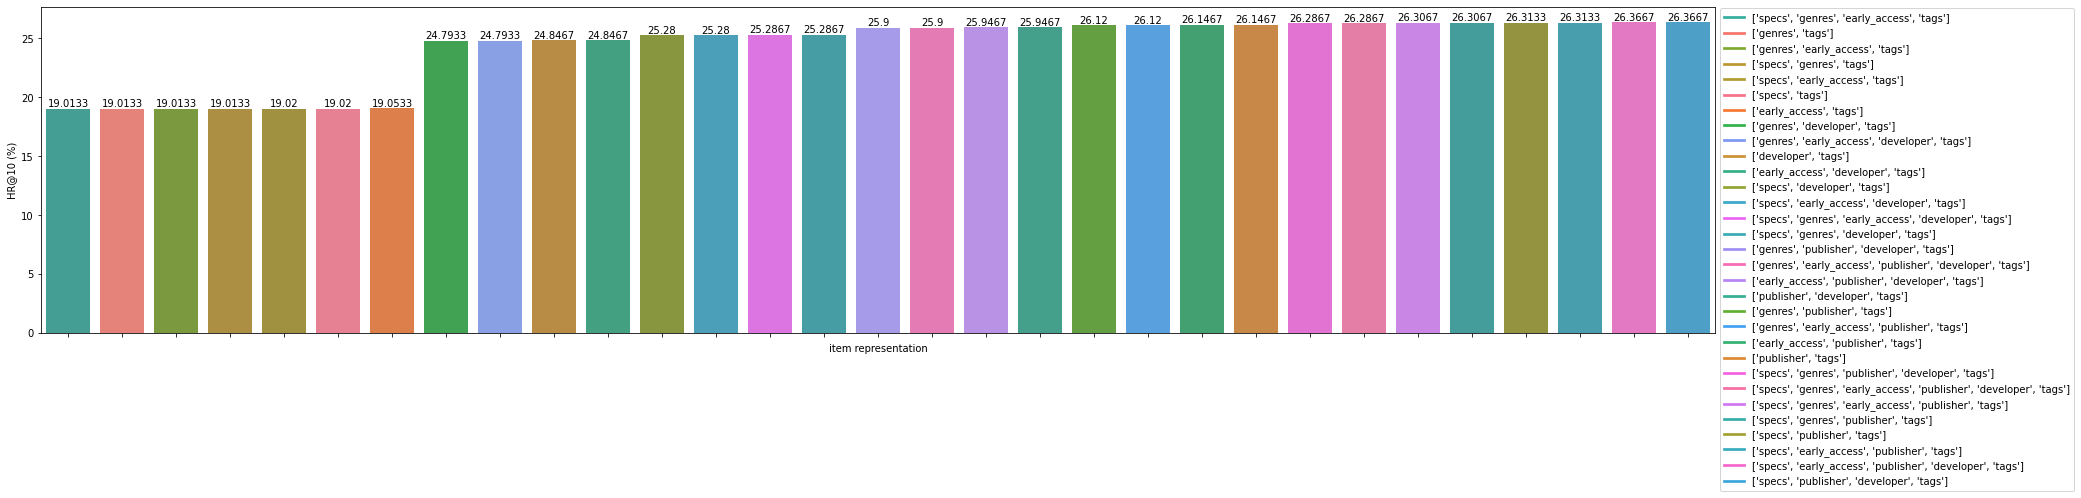

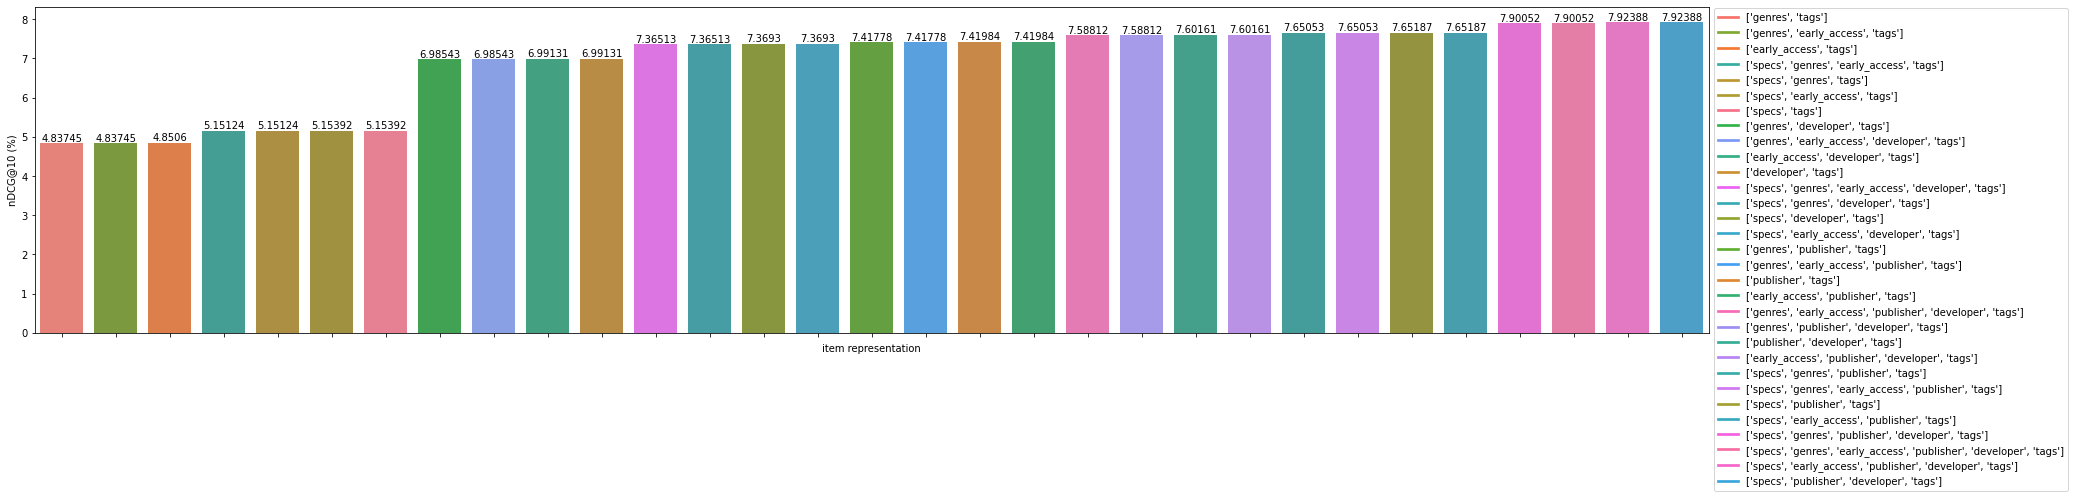

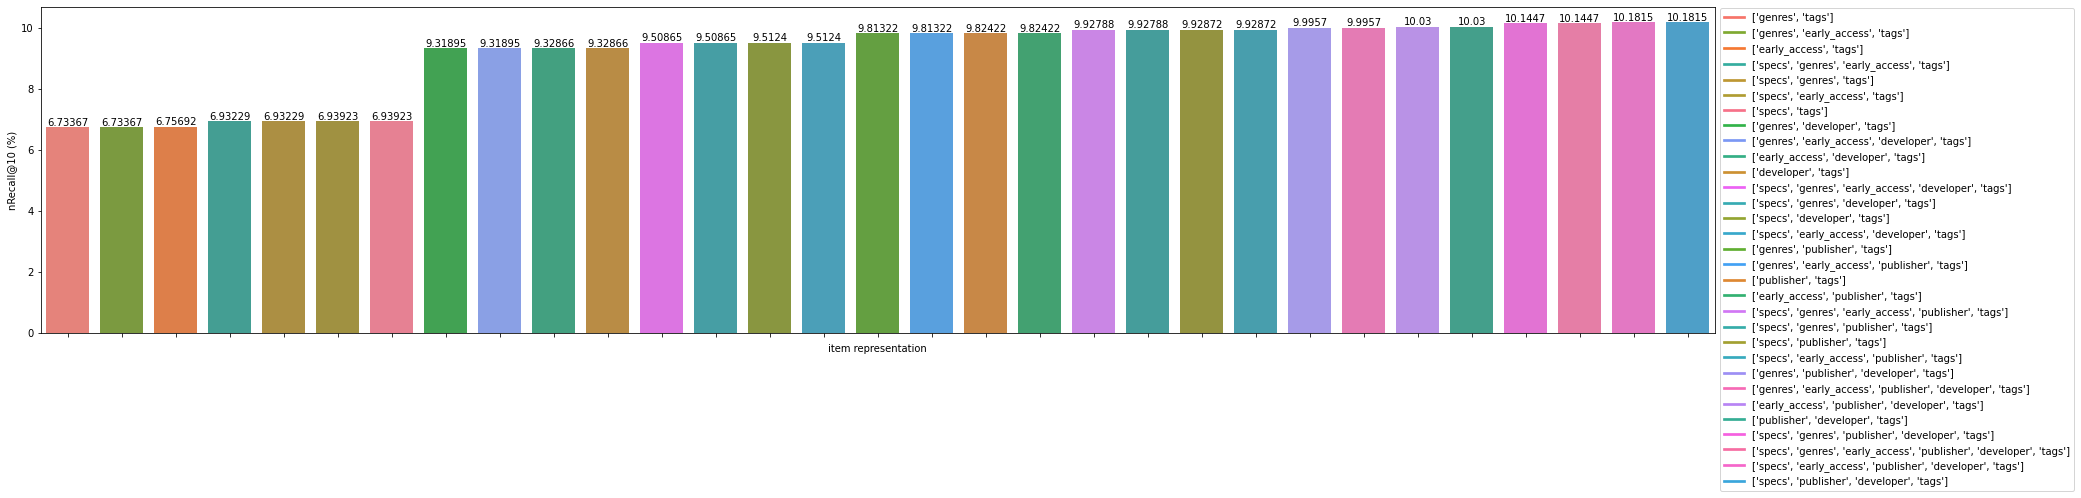

In [2]:
with open('./evaluation/representations.pickle', 'rb') as handle:
    labels = pickle.load(handle)
    
with open('./evaluation/representations_results.pickle', 'rb') as handle:
    results = pickle.load(handle)
    
labels = [str(label) for label in labels]
for key in results[0].keys():
    if key[-2:] == '10' and key[:-3] not in ['ideal_recall', 'recall']:
        values = [result[key] for result in results]
        visualize(labels, values, key, 'item representation')

The results show that we can get a significant quantitative improvement from the item representation. More specifically, 'publisher' results in the largest performance increase when it is added to the item representation in addition to the baseline recommender's 'genres' and 'tags'. An explanation for this is that a 'publisher' can be seen as a type of 'metatag'. Publishers usually publish similar games, which is why they provide an alternative grouping for the items, similar to 'genres'.

### Optimization 2: Weighting schemes for user vector construction

The previous section focused on an improved item representation. Note that this is one of the three main components in the content-based recommender. The other two are the construction of the user vector and the filtering component.
The following optimization focuses on an improved construction of the user vector, based on a weighting scheme. This technique is inspired by the idea that not all inventory items of a user are representative of the user's interests. Therefore, it would be useful to assign higher weights to games that have a high playtime, good overall user rating, high number of reviews on steam or games that have been liked by the user. By default, the weight for each game is one, resulting in games being weighted equally. Then, each of the weight options work as follows:

* Playtime: multiplies the weights with the normalized log of the playtime (logarithmic to prevent overfitting on games with very high playtime)
* Sentiment: multiplies the weights with a sentiment score, there are three possible suboptions
    * rating: a score which is based on the overall rating of all reviews for the game on steam
    * n_reviews: a score which is based on the number of reviews for the game on steam
    * mixed: rating * n_reviews
* Reviews: sets the weight of the game to 1 for likes and to 0 for dislikes

The visualization shows the results across all possible weighting schemes.

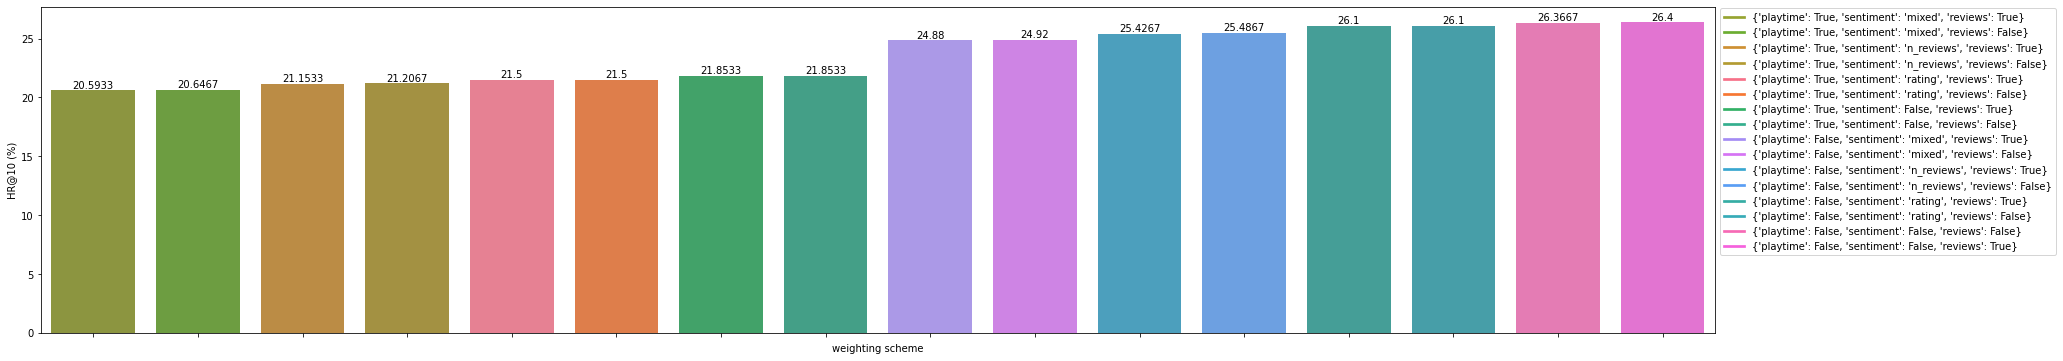

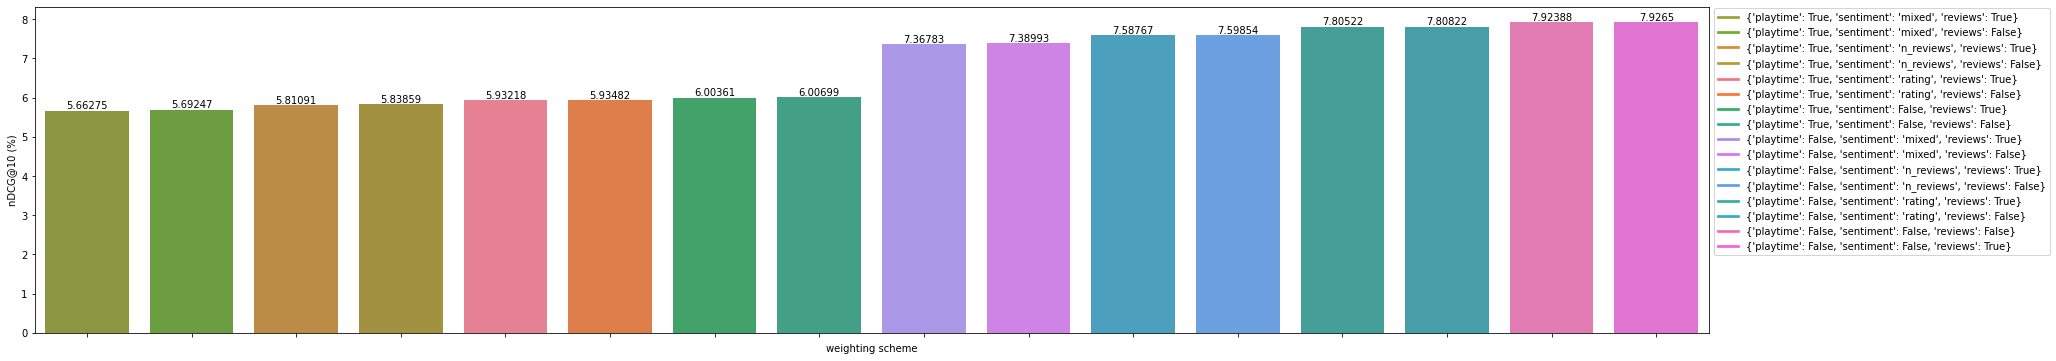

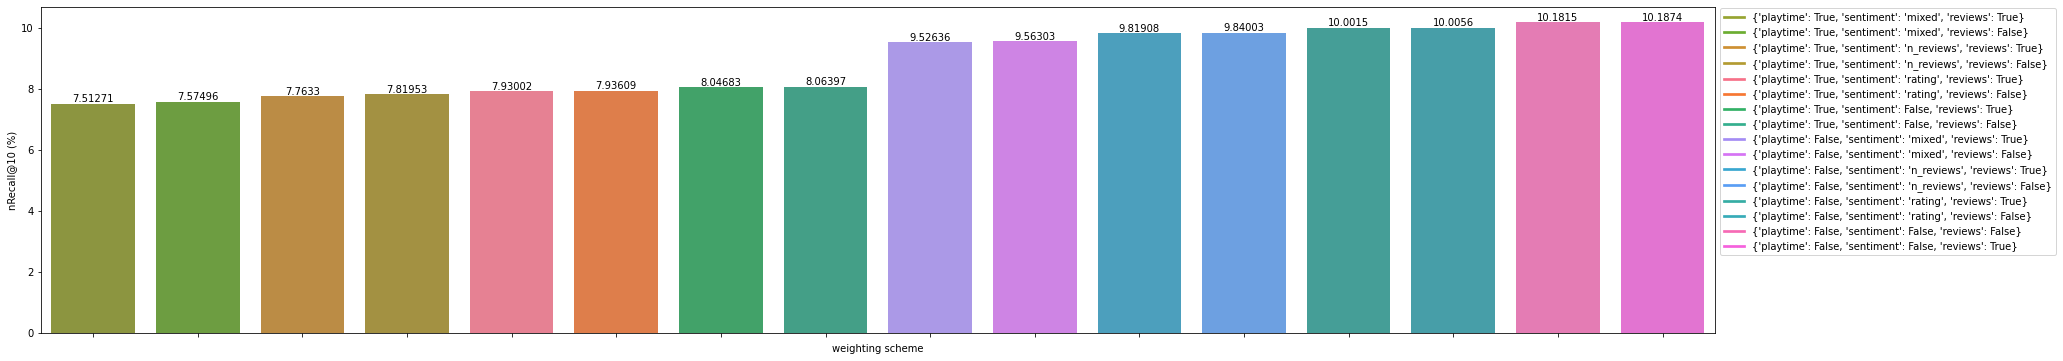

In [3]:
with open('./evaluation/weighting_schemes.pickle', 'rb') as handle:
    labels = pickle.load(handle)
    
with open('./evaluation/weighting_schemes_results.pickle', 'rb') as handle:
    results = pickle.load(handle)
    
labels = [str(label) for label in labels]
for key in results[0].keys():
    if key[-2:] == '10' and key[:-3] not in ['ideal_recall', 'recall']:
        values = [result[key] for result in results]
        visualize(labels, values, key, 'weighting scheme')

Unfortunately, the results show a decreased quantitative performance when we use playtime weighting. However, we think that this is due to our evaluation method. 
Recall that we train and evaluate on random splits of the user's inventory. This means that there are also items in the inventory which the user has never played, and these should be guessed by the recommender in order to improve the qualitative scores. However, by using a playtime weighting, the focus of the recommender shifts to games that the user would actually like to play, therefore ultimately increasing quantitative performance.

This is why we perform qualitative evaluation for an ideal weighting scheme in the [qualitative evaluation notebook](qualitative_evaluation.ipynb). There, we denote that the use of a weighting scheme does improve the recommendations qualitatively on our own user inventories.

### Optimization 3: Dimensionality reduction

The first optimization increases the dimensionality of the item space significantly. Therefore, the larger item representations may not see an improvement, while still providing useful information.
We now take a look at dimensionality reduction techniques in order to inspect if we could improve performance even further if the dimensionality of the item space has been reduced.

The downside of this approach is that the prediction runtime increases significantly, as nearest neighbours methods on dense vectors are less performant when making use of the cosine distance.

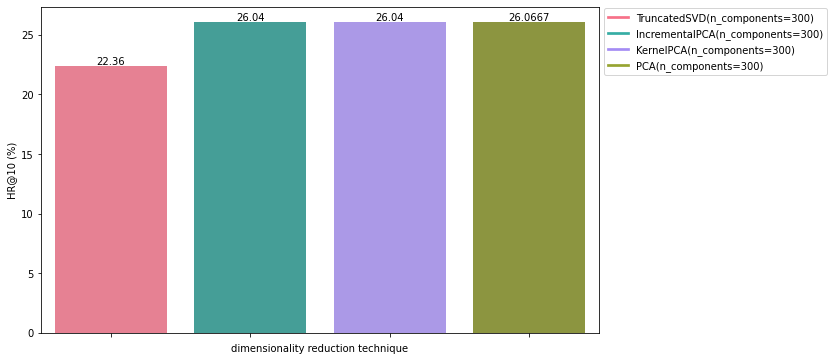

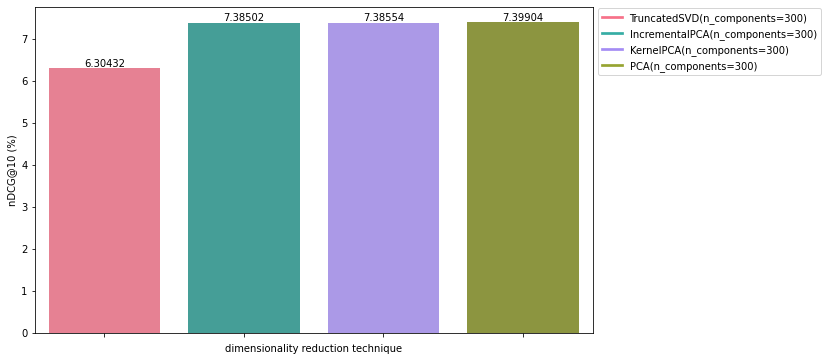

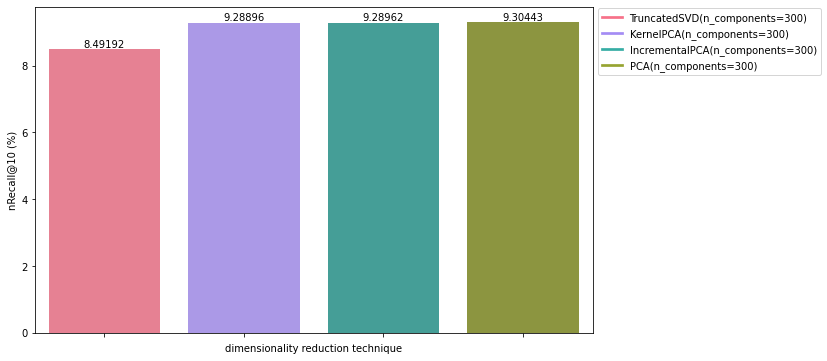

In [4]:
with open('./evaluation/dim_reduction.pickle', 'rb') as handle:
    labels = pickle.load(handle)
    
with open('./evaluation/dim_reduction_results.pickle', 'rb') as handle:
    results = pickle.load(handle)
    
labels = [str(label) for label in labels]
for key in results[0].keys():
    if key[-2:] == '10' and key[:-3] not in ['ideal_recall', 'recall']:
        values = [result[key] for result in results]
        visualize(labels, values, key, 'dimensionality reduction technique', width=10)

We see that PCA is the superior method to use as a dimensionality reduction technique. The difference between PCA and SVD is that PCA first centers the data. For this reason, it expects a dense matrix representation as input. Between the different PCA methods, there is a negligible performance difference. Therefore, we opt to use the default PCA method in what follows.

The following visualizations evaluate the performance of the PCA method for multiple output sizes. Note that as the output size increases, the prediction runtime increases as well. Therefore, we limit the number of components to a maximum of 500.

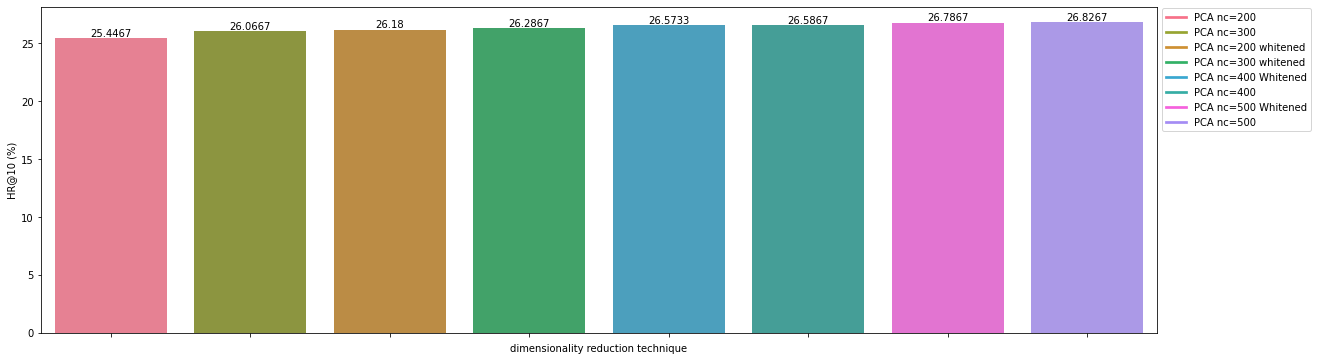

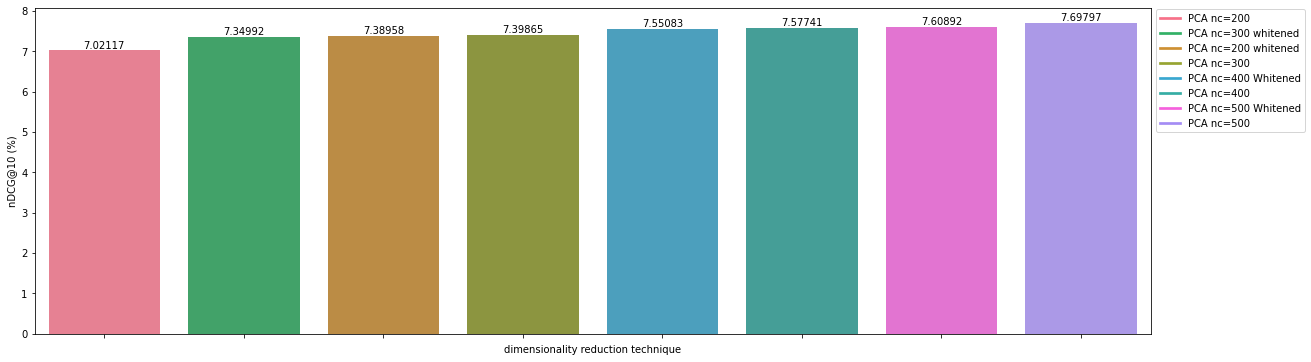

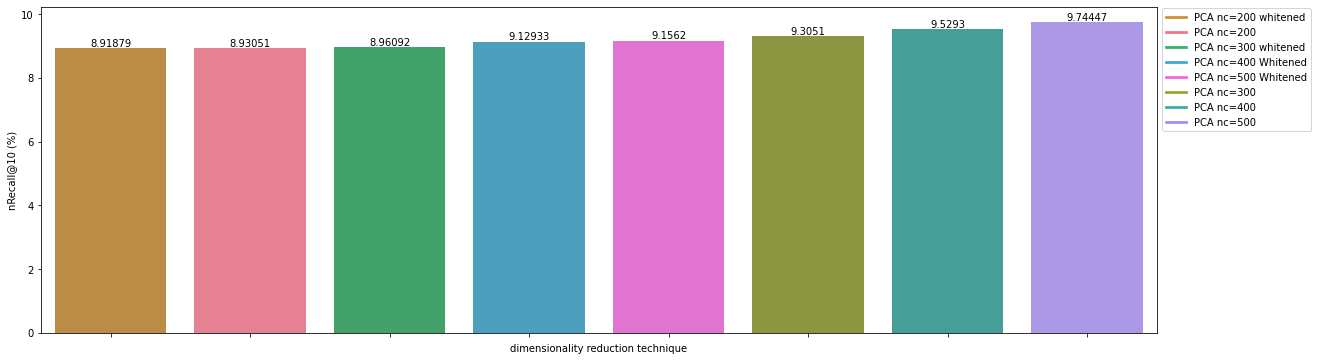

In [5]:
with open('./evaluation/v3/quantitative/ImprovedRec_PCA.pickle.gz', 'rb') as handle:
    labels = pickle.load(handle)
    
with open('./evaluation/v3/quantitative/ImprovedRec_PCA_results.pickle.gz', 'rb') as handle:
    results = pickle.load(handle)
    
labels = [str(label) for label in labels]
for key in results[0].keys():
    if key[-2:] == '10' and key[:-3] not in ['ideal_recall', 'recall']:
        values = [average(result[key]) for result in results]
        visualize(labels, values, key, 'dimensionality reduction technique', width=20)

Unfortunately, the PCA method does not provide an improvement in terms of quantitative performance when compared to the content-based recommender with improved item representation. However, this is with using only the limited item representation that performed best during the hyper-paramater optimization experiment.

We can still check whether using all available data, and reducing the representation for this, results in a performance benefit due to being able to capture more details:

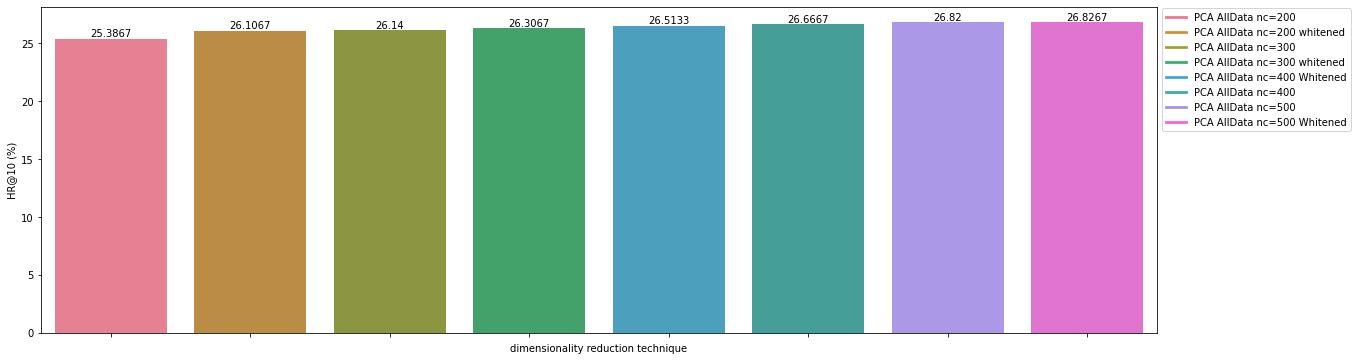

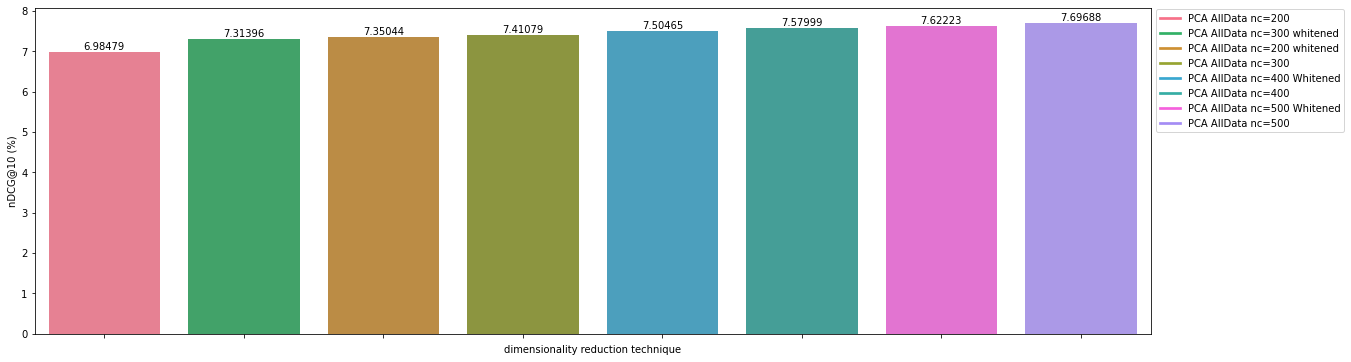

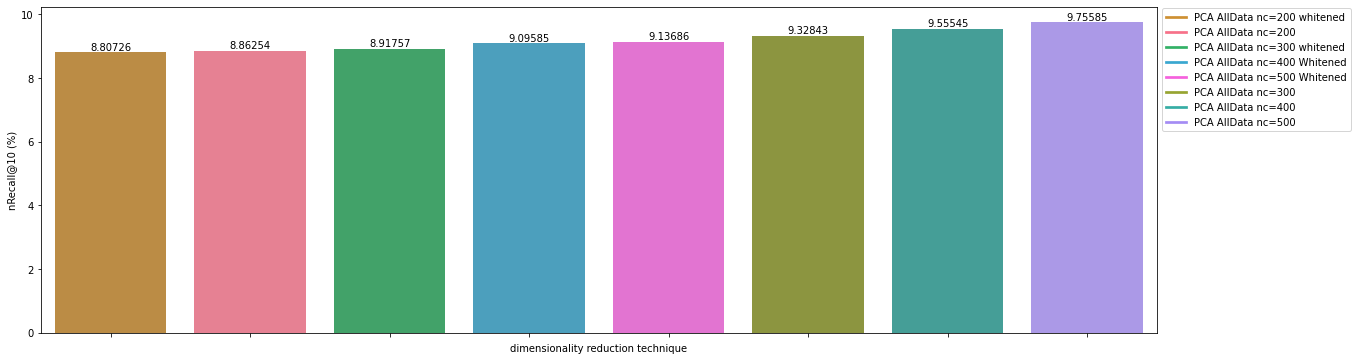

In [6]:
with open('./evaluation/v3/quantitative/ImprovedRec_PCA_alldata.pickle.gz', 'rb') as handle:
    labels = pickle.load(handle)
    
with open('./evaluation/v3/quantitative/ImprovedRec_PCA_alldata_results.pickle.gz', 'rb') as handle:
    results = pickle.load(handle)
    
labels = [str(label) for label in labels]
for key in results[0].keys():
    if key[-2:] == '10' and key[:-3] not in ['ideal_recall', 'recall']:
        values = [average(result[key]) for result in results]
        visualize(labels, values, key, 'dimensionality reduction technique', width=20)

Sadly, we do not observe much differences to the previously obtained results. Therefore, we can conclude that dimensionality reduction is not suitable for the features of the given dataset. This does not mean that it won't work for other datasets, however, as item representations can vastly differ for different datasets. If the item representations would have even vastly higher dimensionality, we may see a benefit in the use of dimensionality reduction.

# Final overview

The following visualizations provide a final overview of the quantitative results for the most interesting configurations of the content-based recommender.
These results have been obtained by running on all users within the dataset.

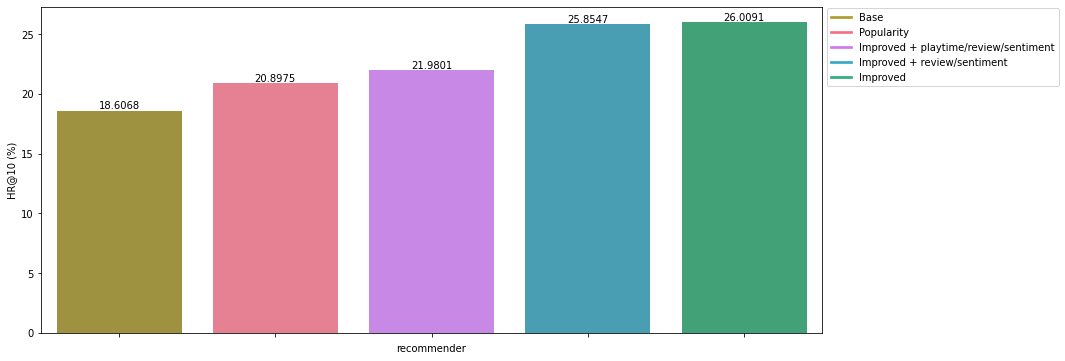

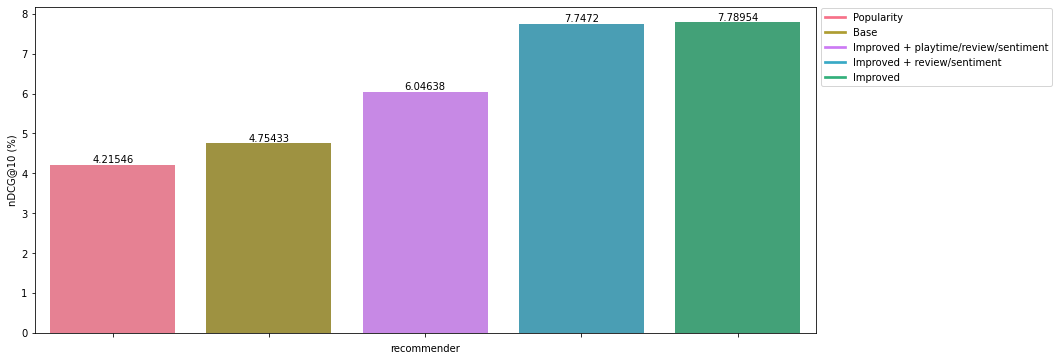

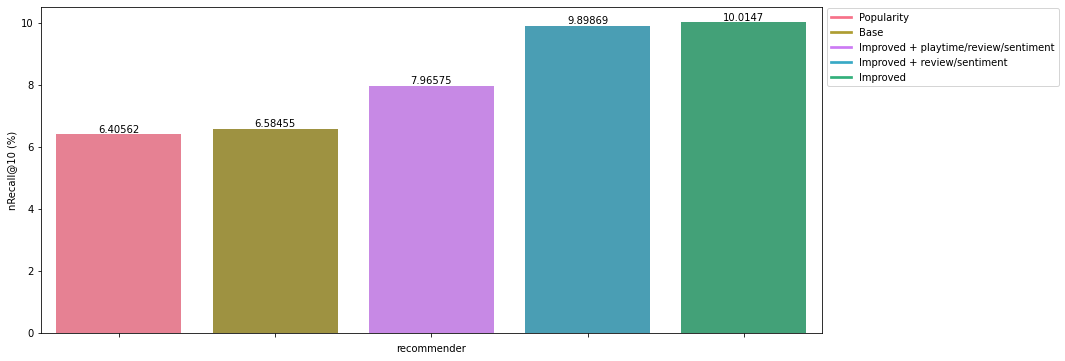

In [9]:
results = []
labels = ['PopBased', 'BaseRecommender', 'ImprovedRec_none', 'ImprovedRec_sentiment', 'ImprovedRec_allweighting']
actual_labels = ['Popularity', 'Base', 'Improved', 'Improved + review/sentiment', 'Improved + playtime/review/sentiment']

for label in labels:
    with open(f'./evaluation/v3/quantitative/{label}.pickle.gz', 'rb') as handle:
        results.append(pickle.load(handle))
    
for key in results[0].keys():
    if key[-2:] == '10' and key[:-3] not in ['ideal_recall', 'recall']:
        values = [average(result[key]) for result in results]
        visualize(actual_labels, values, key, 'recommender', width=14)

We see that for the metrics@10, we've been able to provide a significant improvement to the content-based recommender.

The following visualization shows that this also generalized to metrics@5 and metrics@20:

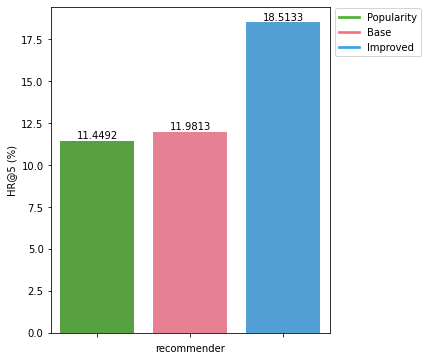

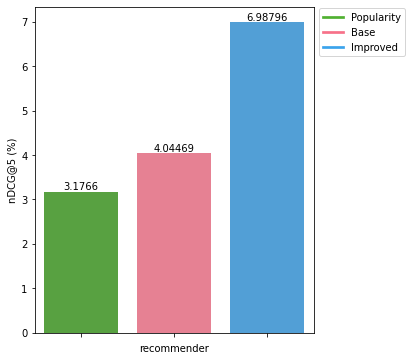

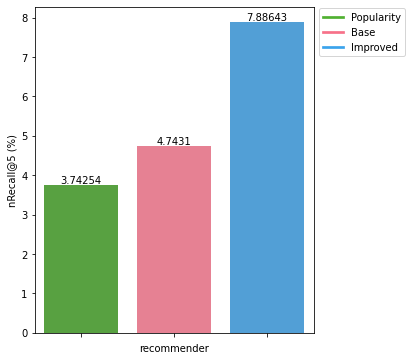

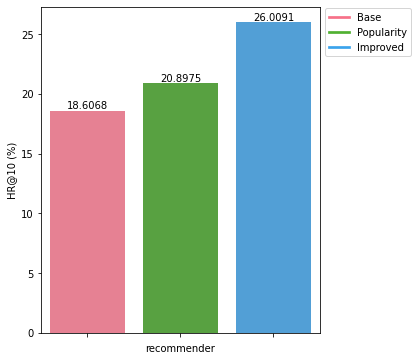

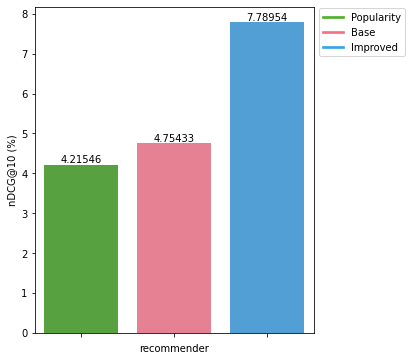

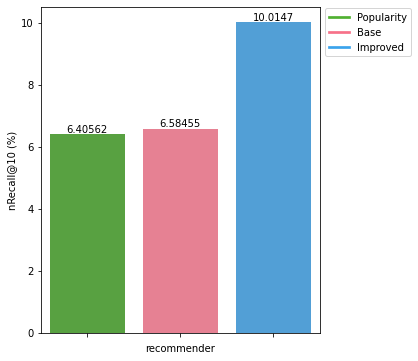

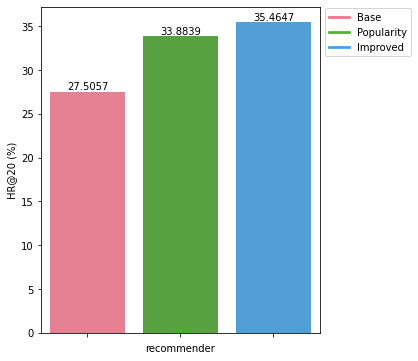

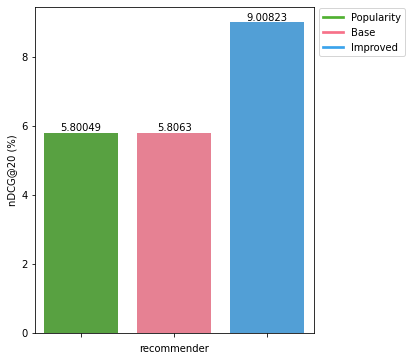

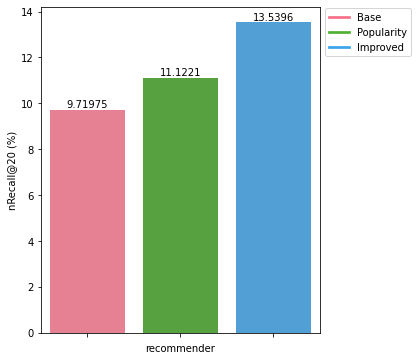

In [16]:
results = []
labels = ['BaseRecommender', 'PopBased', 'ImprovedRec_none']
actual_labels = ['Base', 'Popularity', 'Improved']

for label in labels:
    with open(f'./evaluation/v3/quantitative/{label}.pickle.gz', 'rb') as handle:
        results.append(pickle.load(handle))
    
for key in results[0].keys():
    if key[-1:] == '5' and key[:-2] not in ['ideal_recall', 'recall']:
        values = [average(result[key]) for result in results]
        visualize(actual_labels, values, key, 'recommender', width=5)
        
for key in results[0].keys():
    if key[-2:] == '10' and key[:-3] not in ['ideal_recall', 'recall']:
        values = [average(result[key]) for result in results]
        visualize(actual_labels, values, key, 'recommender', width=5)
    
for key in results[0].keys():
    if key[-2:] == '20' and key[:-3] not in ['ideal_recall', 'recall']:
        values = [average(result[key]) for result in results]
        visualize(actual_labels, values, key, 'recommender', width=5)